In [1]:
import os
import json
import sys
import subprocess
import traceback

# These are the paths to where SageMaker mounts interesting things in your container.
prefix = '/opt/ml/'
input_path = os.path.join(prefix,'input/data')
output_path = os.path.join(prefix, 'output')
model_path = os.path.join(prefix, 'model')
param_path = os.path.join(prefix, 'input/config/hyperparameters.json')

In [2]:
with open(param_path, 'r') as tc:
    training_params = json.load(tc)
training_params

{}

In [3]:
print('aaa')

aaa


In [4]:
print(os.listdir('/opt/ml'))
print(os.listdir('/opt/ml/input/data'))
print(os.listdir('/opt/ml/input/data/train'))
print(os.listdir('/opt/ml/input/data/validation'))

['code', 'input', 'output', 'model']
['validation', 'train']
['examples']
['examples']


In [5]:
'''
Copyright (c) 2018 Norio Tamada
Released under the MIT license
https://github.com/darecophoenixx/wordroid.sblo.jp/blob/master/lib/keras_ex/gkernel/LICENSE.md
'''

import numpy as np
from keras import initializers, constraints
from keras.engine.topology import Layer
from keras import backend as K

class GaussianKernel(Layer):
    
    def __init__(self, num_landmark, num_feature,
                 kernel_initializer='glorot_uniform',
                 kernel_constraint=None,
                 kernel_gamma='auto',
                 **kwargs):
        '''
        num_landmark:
            number of landmark
            that was number of output features
        num_feature:
            depth of landmark
            equal to inputs.shape[1]
        kernel_gamma:
            kernel parameter
            if 'auto', use 1/(2 * d_mean**2)
            d is distance between samples and landmark
            d_mean is mean of d
        '''
        super(GaussianKernel, self).__init__(**kwargs)
        
        self.output_dim = num_landmark
        self.num_feature = num_feature
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_constraint = constraints.get(kernel_constraint)

        # kernel parameter
        self.kernel_gamma= kernel_gamma

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.output_dim, self.num_feature),
                                      initializer=self.kernel_initializer,
                                      constraint=self.kernel_constraint)
        super(GaussianKernel, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, training=None):
        return self.gauss(x, self.kernel, self.kernel_gamma)
    
    def gauss(self, x, landmarks, gamma):
        x2 = K.sum(K.square(x), axis=1)
        x2 = K.reshape(x2, (-1,1))
        x2 = K.repeat_elements(x2, self.output_dim, axis=1)
        lm2 = K.sum(K.square(landmarks), axis=1)
        xlm = K.dot(x, K.transpose(landmarks))
        
        ret = x2 + lm2 - 2*xlm
        if gamma == 'auto':
            '''
            gamma is calculated by each batch
            '''
            d = K.sqrt(ret)
            d_mean = K.mean(d)
            gamma = 1. / (2. * d_mean**2)
        ret = K.exp(-gamma * ret)
        return ret



class GaussianKernel2(Layer):
    
    def __init__(self, landmarks, **kwargs):
        '''
        landmarks:
            fixed landmarks using
        '''
        super(GaussianKernel2, self).__init__(**kwargs)
        self.landmarks = landmarks.astype(np.float32)
        self.num_landmark, self.num_feature = landmarks.shape
        self.output_dim = self.num_landmark
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        
        self.gamma_elm = self.add_weight(name='gamma_elm',
                                      shape=(1, ),
                                      initializer=initializers.random_uniform(-2, -1))
        super(GaussianKernel2, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, training=None):
        return self.gauss(x, self.landmarks, K.exp(self.gamma_elm), training=training)
    
    def gauss(self, x, landmarks, gamma, training=None):
        x2 = K.sum(K.square(x), axis=1)
        x2 = K.reshape(x2, (-1,1))
        x2 = K.repeat_elements(x2, self.output_dim, axis=1)
        lm2 = K.sum(K.square(landmarks), axis=1)
        xlm = K.dot(x, K.transpose(landmarks))
        ret = x2 + lm2 - 2*xlm
        ret = K.exp(-gamma * ret)
        return ret


class GaussianKernel3(Layer):
    
    def __init__(self, num_landmark, num_feature,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        '''
        num_landmark:
            number of landmark
            that was number of output features
        num_feature:
            depth of landmark
            equal to inputs.shape[1]
        '''
        super(GaussianKernel3, self).__init__(**kwargs)
        
        self.output_dim = num_landmark
        self.num_feature = num_feature
        self.kernel_initializer = initializers.get(kernel_initializer)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.output_dim, self.num_feature),
                                      initializer=self.kernel_initializer)
        self.gamma_elm = self.add_weight(name='gamma_elm',
                                      shape=(1, ),
                                      initializer=initializers.random_uniform(-2, -1))
        super(GaussianKernel3, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, training=None):
        return self.gauss(x, self.kernel, K.exp(self.gamma_elm))
    
    def gauss(self, x, landmarks, gamma, training=None):
        x2 = K.sum(K.square(x), axis=1)
        x2 = K.reshape(x2, (-1,1))
        x2 = K.repeat_elements(x2, self.output_dim, axis=1)
        lm2 = K.sum(K.square(landmarks), axis=1)
        xlm = K.dot(x, K.transpose(landmarks))
        ret = x2 + lm2 - 2*xlm
        ret = K.exp(-gamma * ret)
        return ret


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [7]:
import os.path
import itertools
from itertools import chain

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import tensorflow as tf

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, AveragePooling2D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, GlobalAveragePooling2D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, GlobalMaxPooling3D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical, plot_model, Sequence
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [8]:
from PIL import Image
from zipfile import ZipFile
import h5py
import cv2
from tqdm import tqdm

In [9]:
train_labels = pd.read_csv(os.path.join(input_path, 'train', "examples"), header=None)
print(train_labels.shape)
train_labels.head(10)

(50000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
valid_labels = pd.read_csv(os.path.join(input_path, 'validation', "examples"), header=None)
print(valid_labels.shape)
valid_labels.head(10)

(10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


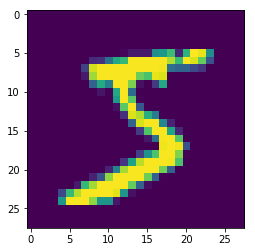

In [11]:
plt.imshow(train_labels.values[0,1:].reshape((28,28)))

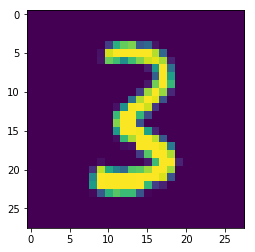

In [12]:
plt.imshow(valid_labels.values[0,1:].reshape((28,28)))